In [39]:
# os
import os

# データ整形用
import pandas as pd

# ベイズ最適化
import optuna

# 構造学習用
from causalnex.structure.notears import from_pandas_lasso
from sklearn.preprocessing import StandardScaler

# 可視化用
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import networkx as nx

/home/yarita/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
data = pd.read_excel('../data/231021-1110_AI用qPCRデータ.xlsx', header=1, index_col=0)
data = data.dropna()
data = data.reset_index(drop=True)
data.shape

(211, 33)

In [36]:
# 平均0, 分散1の標準化
scaler = StandardScaler()
norm_data_array = scaler.fit_transform(data)
norm_data = pd.DataFrame(norm_data_array, columns=data.columns)
norm_data.head(3)

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,-0.478000,-0.145310,-0.186724,-0.126510,-0.296711,-0.196438,-0.139036,-0.099555,-0.150187,-0.270711,...,-0.304500,0.040025,-1.144075,0.233070,-0.251672,-0.181602,-0.634371,-0.893224,-0.429545,-0.422568
1,-0.383090,-0.128682,-0.145902,-0.489821,-0.295543,-0.142752,-0.133647,-0.091603,-0.063683,-0.124194,...,-0.152559,0.058741,-1.142809,0.286622,-0.169224,0.018884,-0.543704,-0.337397,-0.029556,-0.000408
2,-0.383244,-0.603811,-0.145725,-0.490193,-0.202170,-0.196047,0.304820,-0.097057,-0.150002,0.169103,...,-0.153226,0.047084,-1.135013,0.269307,-0.167799,0.018553,-0.361239,-0.327326,-0.023438,0.014527


X (DataFrame) – input data.
beta (float) – Constant that multiplies the lasso term.
max_iter (int) – max number of dual ascent steps during optimisation.
h_tol (float) – exit if h(W) < h_tol (as opposed to strict definition of 0).
w_threshold (float) – fixed threshold for absolute edge weights.

In [40]:
# ベイズ最適化
def objective(trial):
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    w_threshold = trial.suggest_float('w_threshold', 0.0, 5.0)
    beta = trial.suggest_float('beta', 1e-4, 1e-1, log=True)  # ログスケールでlassoの値を探索

    # NOTEARSアルゴリズムを用いて構造学習を実施
    # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
    sm = from_pandas_lasso(norm_data,
                           max_iter=max_iter,
                           w_threshold=w_threshold,
                           beta=beta
                           )                           

    # 学習された構造のスコアを計算（スコアリング方法はプロジェクトにより異なる）
    score = calculate_score(sm)

    return score

# スコアリング関数（例：エッジ数でスコアリング）
def calculate_score(sm):
    return -len(sm.edges)  # エッジの数が少ないほどスコアが高くなるように設定

# スコア(エッジの数)を最大化するように設定
study = optuna.create_study(direction='maximize')
# 100回の試行で最適化
study.optimize(objective, n_trials=100)
# ログ非表示
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# 最適なハイパーパラメータを出力
best_params = study.best_params
print(best_params)

[I 2023-11-16 16:13:08,870] A new study created in memory with name: no-name-73d03bd2-f0b1-47b8-ab18-de3fb1248a68
[I 2023-11-16 16:13:49,855] Trial 0 finished with value: 0.0 and parameters: {'max_iter': 762, 'w_threshold': 4.064444834361466, 'beta': 0.0001493752769476649}. Best is trial 0 with value: 0.0.
[I 2023-11-16 16:14:57,192] Trial 1 finished with value: 0.0 and parameters: {'max_iter': 441, 'w_threshold': 3.4848196849987407, 'beta': 0.005004023660231129}. Best is trial 0 with value: 0.0.
[I 2023-11-16 16:15:30,986] Trial 2 finished with value: -24.0 and parameters: {'max_iter': 575, 'w_threshold': 0.546158557505555, 'beta': 0.05176225869671965}. Best is trial 0 with value: 0.0.
[I 2023-11-16 16:16:36,861] Trial 3 finished with value: 0.0 and parameters: {'max_iter': 287, 'w_threshold': 3.8347112016532137, 'beta': 0.004937579632197863}. Best is trial 0 with value: 0.0.
[I 2023-11-16 16:17:25,291] Trial 4 finished with value: -7.0 and parameters: {'max_iter': 923, 'w_threshold':

In [37]:
beta=best_params['beta']
max_iter=best_params['max_iter']
w_threshold=best_params['w_threshold']
sm = from_pandas_lasso(X=norm_data, beta=beta, max_iter=max_iter, w_threshold=w_threshold)

In [29]:
sm

In [32]:
print(sm.nodes())
print(sm.edges())

['glk', 'agp', 'yihX', 'pgm', 'ptsG', 'malx', 'crr', 'galM', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'glpX', 'fbp', 'pfkB', 'pfkA', 'fbaB', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'ytjc', 'gpmM', 'eno', 'pykF', 'pykA', 'ppsA']
[('glk', 'ascF'), ('glk', 'bglB'), ('agp', 'galM'), ('agp', 'bglA'), ('agp', 'bglB'), ('agp', 'tpiA'), ('agp', 'ytjc'), ('agp', 'pykA'), ('yihX', 'pgm'), ('yihX', 'ptsG'), ('yihX', 'glpX'), ('pgm', 'yihX'), ('pgm', 'ptsG'), ('pgm', 'glpX'), ('pgm', 'pykF'), ('ptsG', 'yihX'), ('ptsG', 'pgm'), ('malx', 'glk'), ('malx', 'yihR'), ('malx', 'ascF'), ('malx', 'bglA'), ('malx', 'bglB'), ('crr', 'ascB'), ('galM', 'agp'), ('galM', 'bglA'), ('galM', 'bglB'), ('galM', 'pfkB'), ('galM', 'pfkA'), ('galM', 'tpiA'), ('galM', 'ytjc'), ('galM', 'pykA'), ('yihR', 'glk'), ('yihR', 'ascF'), ('yihR', 'chbF'), ('yihR', 'bglA'), ('yihR', 'bglB'), ('yihR', 'gpmM'), ('yeaD', 'crr'), ('yeaD', 'ascB'), ('yeaD', 'pfkA'), ('yeaD', 'gpmM'), ('ascF', 'malx'), ('asc

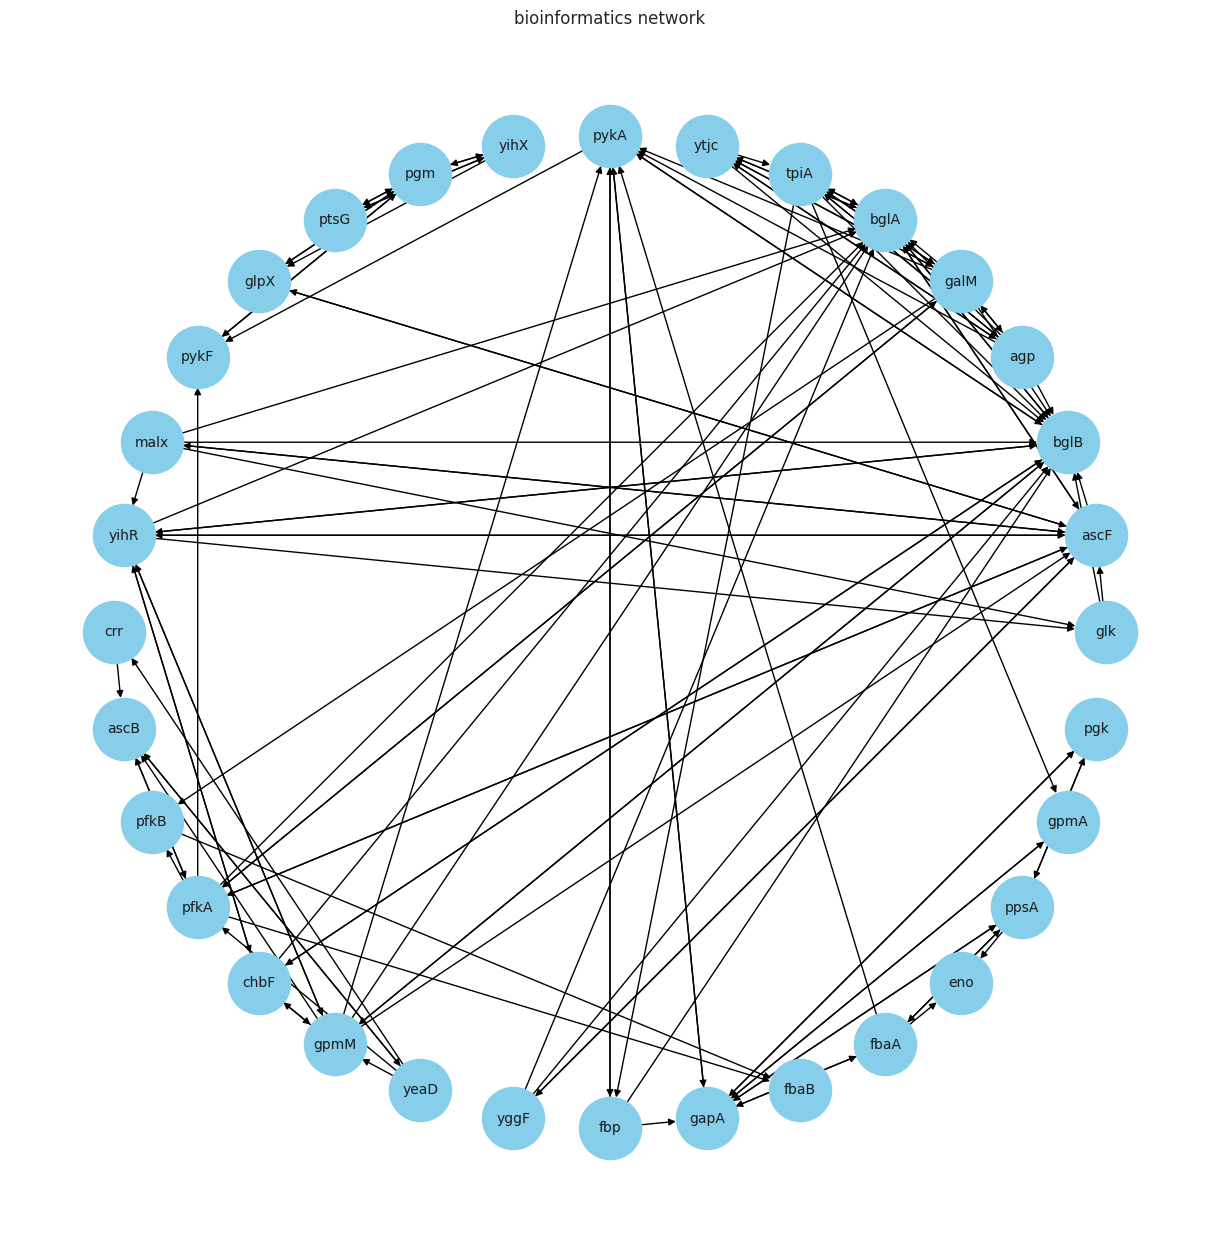

In [34]:
# 連番生成関数
def create_filename(base_name, directory='.', extension='.png'):
    counter = 1
    while True:
        file_name = f"{base_name}_{counter}{extension}"
        full_path = os.path.join(directory, file_name)
        if not os.path.exists(full_path):
            return full_path
        counter += 1

def draw_graph(sm, w_threshold):
    sns.set(style="whitegrid")

    # 構造モデルsmをnetworkxのグラフに変換
    G = nx.DiGraph(sm.edges())

    # グラフの描画
    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(G)  # ノードの配置
    nx.draw(G, pos, with_labels=True, node_size=2000, edge_color="black", node_color="skyblue", font_size=10)
    plt.title("bioinformatics network")
    plt.savefig(f"./bio_networks/bio_network_th{w_threshold}.png", format="png", dpi=300, bbox_inches='tight')

draw_graph(sm, w_threshold)